In [31]:
import os
import sys
import matplotlib.pyplot as plt

import matplotlib.image as iread
import tensorflow as tf
from PIL import Image
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
cwd = os.getcwd()

#for sliding window for calculating histogram
#stide = 50, incr stands for this
cell = [8, 8]
incr = [8,8]
bin_num = 8
im_size = [128,256]

#image path must be wrt current working directory
def create_array(image_path):
	
	image = Image.open(os.path.join(cwd,image_path)).convert('L')
	image_array = np.asarray(image,dtype=float)
	
	return image_array

#uses a [-1 0 1 kernel]
def create_grad_array(image_array):
	image_array = Image.fromarray(image_array)
	if not image_array.size == im_size:
		image_array = image_array.resize(im_size, resample=Image.BICUBIC)
	
	image_array = np.asarray(image_array,dtype=float)
	
	# gamma correction
	image_array = (image_array)**2.5

	# local contrast normalisation
	image_array = (image_array-np.mean(image_array))/np.std(image_array)
	max_h = 256
	max_w = 128

	grad = np.zeros([max_h, max_w])
	mag = np.zeros([max_h, max_w])
	for h,row in enumerate(image_array):
		for w, val in enumerate(row):
			if h-1>=0 and w-1>=0 and h+1<max_h and w+1<max_w:
				dy = image_array[h+1][w]-image_array[h-1][w]
				dx = row[w+1]-row[w-1]+0.0001
				grad[h][w] = np.arctan(dy/dx)*(180/np.pi)
				if grad[h][w]<0:
					grad[h][w] += 180
				mag[h][w] = np.sqrt(dy*dy+dx*dx)
	
	return grad,mag

def write_hog_file(filename, final_array):
	print('Saving '+filename+' ........\n')
	np.savetxt(filename,final_array)

def read_hog_file(filename):
	return np.loadtxt(filename)

def calculate_histogram(array,weights):
	bins_range = (0, 180)
	bins = bin_num
	hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)

	return hist

def create_hog_features(grad_array,mag_array):
	max_h = int(((grad_array.shape[0]-cell[0])/incr[0])+1)
	max_w = int(((grad_array.shape[1]-cell[1])/incr[1])+1)
	cell_array = []
	w = 0
	h = 0
	i = 0
	j = 0

	#Creating 8X8 cells
	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_hist = grad_array[h:h+cell[0],w:w+cell[1]]
			for_wght = mag_array[h:h+cell[0],w:w+cell[1]]
			
			val = calculate_histogram(for_hist,for_wght)
			cell_array.append(val)
			j += 1
			w += incr[1]

		i += 1
		h += incr[0]

	cell_array = np.reshape(cell_array,(max_h, max_w, bin_num))
	#normalising blocks of cells
	block = [2,2]
	#here increment is 1

	max_h = int((max_h-block[0])+1)
	max_w = int((max_w-block[1])+1)
	block_list = []
	w = 0
	h = 0
	i = 0
	j = 0

	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_norm = cell_array[h:h+block[0],w:w+block[1]]
			mag = np.linalg.norm(for_norm)
			arr_list = (for_norm/mag).flatten().tolist()
			block_list += arr_list
			j += 1
			w += 1

		i += 1
		h += 1

	#returns a vextor array list of 288 elements
	return block_list

#image_array must be an array
#returns a 288 features vector from image array
def apply_hog(image_array):
	gradient,magnitude = create_grad_array(image_array)
	hog_features = create_hog_features(gradient,magnitude)
	hog_features = np.asarray(hog_features,dtype=float)
	hog_features = np.expand_dims(hog_features,axis=0)

	return hog_features

#path must be image path
#returns final features array from image_path
def hog_from_path(image_path):
	image_array = create_array(image_path)
	final_array = apply_hog(image_array)
	
	return final_array

#Creates hog files
def create_hog_file(image_path,save_path):
	image_array = create_array(image_path)
	final_array = apply_hog(image_array)
	write_hog_file(save_path,final_array)


In [1]:
import os
import sys
import matplotlib.pyplot as plt

import matplotlib.image as iread
import tensorflow as tf
from PIL import Image
import numpy as np

In [2]:
import pandas as pd

In [3]:
my_data_dir = 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\new_train_data'


In [4]:
os.listdir(my_data_dir) 

['test_set', 'training_set']

In [5]:
test_set_path = my_data_dir+'\\test_set\\'
training_set_path = my_data_dir+'\\training_set\\'


In [6]:
os.listdir(training_set_path)

['beaches',
 'bus',
 'dinosaurs',
 'elephants',
 'flowers',
 'foods',
 'horses',
 'monuments',
 'mountains_and_snow',
 'peolpe_and_villages_in_Africa']

In [7]:
os.listdir(training_set_path)[0]

'beaches'

In [8]:
os.listdir(training_set_path+'\\beaches')[0]

'110.jpg'

In [9]:
para_cell = training_set_path+'\\beaches'+'\\110.jpg'

In [10]:
from skimage.io import imread

In [11]:
para_img= imread(para_cell)

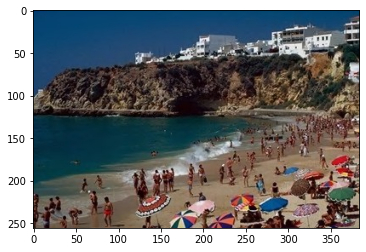

In [12]:
plt.imshow(para_img)

In [13]:
para_img.shape

(256, 384, 3)

In [14]:
beaches_path = training_set_path+'\\beaches'
beaches_len=len(os.listdir(beaches_path))


In [15]:
beaches_len 

90

In [17]:
cwd= 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master'

In [18]:
train_path= os.path.join(cwd,'new_train_data'+'\\training_set\\')

In [19]:
train_path

'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\new_train_data\\training_set\\'

In [20]:
directories = os.listdir(train_path)

# Resizing the training_set and extract HOG feature for each image 

In [21]:
#resizing dataset
from PIL import Image
import glob

In [22]:
# empty lists
image_list = []
resized_images = []

In [23]:
train_path 

'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\new_train_data\\training_set\\'

In [24]:
directories

['beaches',
 'bus',
 'dinosaurs',
 'elephants',
 'flowers',
 'foods',
 'horses',
 'monuments',
 'mountains_and_snow',
 'peolpe_and_villages_in_Africa']

In [24]:
#create new folder for the dataset after resizing 
os.mkdir('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_images')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_images'

In [25]:
# create folder for each class

for item in directories:
    parent_dir='C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset'
    directory=item
    path=os.path.join(parent_dir,directory)
    os.mkdir(path)
    
print(os.listdir('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset'))




['beaches', 'bus', 'dinosaurs', 'elephants', 'flowers', 'foods', 'horses', 'monuments', 'mountains_and_snow', 'peolpe_and_villages_in_Africa', 'test_set', 'training_set']


In [27]:
#Resizing the training dataset
for item in directories: 
    blabla = 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\new_train_data\\training_set\\' + item

    i=0
    for filename in os.listdir(blabla):
        i+=1
        img = Image.open(blabla+'\\'+filename)
        img = img.resize((128,256))
        img.save('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset\\training_set\\'+item+'\\'+str(i)+'.jpg','JPEG')
        


In [28]:
#paths for the resized file and training file 

resized_data_dir= 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset'
training_path = resized_data_dir+'\\training_set\\'


In [29]:
#create a new folder for the HOG features 

os.mkdir('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\hog2_features')

In [30]:
#create folder for each class in the hog_features folder

for item in directories:
    parent_dir='C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\hog2_features'
    directory=item
    path=os.path.join(parent_dir,directory)
    os.mkdir(path)
    
print(os.listdir('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\hog2_features'))


['beaches', 'bus', 'dinosaurs', 'elephants', 'flowers', 'foods', 'horses', 'monuments', 'mountains_and_snow', 'peolpe_and_villages_in_Africa']


In [32]:
#extract the HOG feature for each image in the taining_set

for item in directories: 
    Temp = training_path + item    
    i=0
    for filename in os.listdir(Temp):
        img = Image.open(Temp+'\\'+filename)
        x=os.listdir(Temp)[i]
        #print(x)
        s=x[:-4]+'.txt'
        #print(s)
        saving_path = 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\hog2_features\\features_train\\'+item+'\\'+s
        y=Temp+'\\'+x
        #print(y)
        create_hog_file(y,saving_path)
        mg = read_hog_file(saving_path)
        #print(mg)
        print(mg.shape)
        i+=1

C:\Users\Dear\AppData\Local\Temp\ipykernel_4116\672715564.py:32: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image_array = image_array.resize(im_size, resample=Image.BICUBIC)


Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\1.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\10.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\11.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\12.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\13.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\14.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\15.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\16.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\71.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\72.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\73.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\74.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\75.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\76.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\77.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\beaches\78.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\bus\53.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\bus\54.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\bus\55.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\bus\56.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\bus\57.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\bus\58.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\bus\59.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\bus\6.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_fe

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\dinosaurs\34.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\dinosaurs\35.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\dinosaurs\36.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\dinosaurs\37.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\dinosaurs\38.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\dinosaurs\39.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\dinosaurs\4.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\dinosaurs\40.txt ........

(14880,)
Saving C:\Users\D

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\13.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\14.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\15.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\16.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\17.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\18.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\19.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\2.txt ........

(14880,)
Saving C:\Users\D

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\74.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\75.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\76.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\77.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\78.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\79.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\8.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\elephants\80.txt ........

(14880,)
Saving C:\Users\D

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\flowers\54.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\flowers\55.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\flowers\56.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\flowers\57.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\flowers\58.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\flowers\59.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\flowers\6.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\flowers\60.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\foods\35.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\foods\36.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\foods\37.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\foods\38.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\foods\39.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\foods\4.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\foods\40.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\foods\41.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HO

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\16.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\17.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\18.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\19.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\2.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\20.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\21.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\22.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\79.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\8.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\80.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\81.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\82.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\83.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\84.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\horses\85.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\monuments\59.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\monuments\6.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\monuments\60.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\monuments\61.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\monuments\62.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\monuments\63.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\monuments\64.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\monuments\65.txt ........

(14880,)
Saving C:\Users\D

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\mountains_and_snow\36.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\mountains_and_snow\37.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\mountains_and_snow\38.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\mountains_and_snow\39.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\mountains_and_snow\4.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\mountains_and_snow\40.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\mountains_and_snow\41.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\featu

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\11.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\12.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\13.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\14.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\15.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\16.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\17.txt ........

(14880,)

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\64.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\65.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\66.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\67.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\68.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\69.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_train\peolpe_and_villages_in_Africa\7.txt ........

(14880,)


In [85]:
x='y.jpg' 
x[:-4]

'y'

# Resizing the test_set and extract HOG feature for each image

In [33]:
#create new folder for the dataset after resizing 

os.mkdir('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset\\test_set')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset\\test_set'

In [34]:
# create folder for each class in the test_set before resizing 
for item in directories:
    parent_dir='C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset\\test_set'
    directory=item
    path=os.path.join(parent_dir,directory)
    os.mkdir(path)
    
print(os.listdir('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset\\test_set'))


['beaches', 'bus', 'dinosaurs', 'elephants', 'flowers', 'foods', 'horses', 'monuments', 'mountains_and_snow', 'peolpe_and_villages_in_Africa']


In [35]:
#Resizing the test dataset
for item in directories: 
    blabla = 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\new_train_data\\test_set\\' + item

    i=0
    for filename in os.listdir(blabla):
        i+=1
        img = Image.open(blabla+'\\'+filename)
        img = img.resize((128,256))
        img.save('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\resized_dataset\\test_set\\'+item+'\\'+str(i)+'.jpg','JPEG')
        

In [36]:
test_path = resized_data_dir+'\\test_set\\'

In [37]:
#create new folder for the features in the hog_features for the test_set

os.mkdir('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\hog2_features\\features_test')

In [40]:
# create folder for each class in the test_set before resizing 
for item in directories:
    parent_dir='C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\hog2_features\\features_test'
    directory=item
    path=os.path.join(parent_dir,directory)
    os.mkdir(path)
    
print(os.listdir('C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\hog2_features\\features_test'))

['beaches', 'bus', 'dinosaurs', 'elephants', 'flowers', 'foods', 'horses', 'monuments', 'mountains_and_snow', 'peolpe_and_villages_in_Africa']


In [42]:
#extract the HOG feature for each image in the test_set
for item in directories: 
    Temp = test_path + item    
    i=0
    for filename in os.listdir(Temp):
        img = Image.open(Temp+'\\'+filename)
        x=os.listdir(Temp)[i]
        #print(x)
        s=x[:-4]+'.txt'
        #print(s)
        saving_path2 = 'C:\\Users\\Dear\\Desktop\\FYP\\Testcode3-HOG\\HOG-master\\hog2_features\\features_test\\'+item+'\\'+s
        y=Temp+'\\'+x
        #print(y)
        create_hog_file(y,saving_path2)
        mg = read_hog_file(saving_path2)
        #print(mg)
        print(mg.shape)
        i+=1

C:\Users\Dear\AppData\Local\Temp\ipykernel_4116\672715564.py:32: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image_array = image_array.resize(im_size, resample=Image.BICUBIC)


Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\beaches\1.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\beaches\10.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\beaches\2.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\beaches\3.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\beaches\4.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\beaches\5.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\beaches\6.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\beaches\7.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\

Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\monuments\1.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\monuments\10.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\monuments\2.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\monuments\3.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\monuments\4.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\monuments\5.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\monuments\6.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FYP\Testcode3-HOG\HOG-master\hog2_features\features_test\monuments\7.txt ........

(14880,)
Saving C:\Users\Dear\Desktop\FY